##**Importing the Libraries**

In [ ]:
import string #For string related operations
import numpy as np
from PIL import Image
import os
from pickle import dump, load # Used for serializing or de-serializing python objects


from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

from tqdm import tqdm_notebook as tqdm #Outputs a smart progress bar
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

##**Mounting the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* **Flickr8k_Dataset.zip : An archive of all images in jpeg format**
* **Flickr8k_text.zip : An archive of all text files of images**

##**Unzipping the dataset**

In [ ]:
!unzip '/content/drive/MyDrive/Flickr8k_Dataset.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/__MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: /content/Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: /content/Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: /content/Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: /content/Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: /content/Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: /content/Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: /content/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7

In [ ]:
!unzip '/content/drive/MyDrive/Flickr8k_text.zip' -d '/content'

Archive:  /content/drive/MyDrive/Flickr8k_text.zip
  inflating: /content/CrowdFlowerAnnotations.txt  
  inflating: /content/ExpertAnnotations.txt  
  inflating: /content/Flickr8k.lemma.token.txt  
  inflating: /content/__MACOSX/._Flickr8k.lemma.token.txt  
  inflating: /content/Flickr8k.token.txt  
  inflating: /content/Flickr_8k.devImages.txt  
  inflating: /content/Flickr_8k.testImages.txt  
  inflating: /content/Flickr_8k.trainImages.txt  
  inflating: /content/readme.txt     


**Flickr8k.token.txt comprises of all the image captions. Each image has 5 captions. If you observe you can see that for each image captions are numbered from 0 to 4**

##**Loading and pre-processing the file having captions**

In [ ]:
filename = "/content/Flickr8k.token.txt"

In [ ]:
# Reading the file

def load_doc(filename):
    file = open(filename, 'r') # The file is opened in read only mode
    text = file.read()
    file.close() # Make sure to close the file
    return text

In [ ]:
# Creating a dictionary for all the images with their respective captions
# It will be stored as image : List of 5 captions for that image

def all_img_captions(filename):
    file = load_doc(filename) #Calling the load_doc function to read the file
    captions = file.split('\n') 
    descriptions ={}
    for caption in captions[:-1]: #There is a blank line at the end so we leave it out
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [ ]:
all_img_captions(filename)

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [ ]:
# Function to clean the text

def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation) # Remove punctuations
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions


In [ ]:
# Creating a vocabulary of all the words present in the descriptions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

In [ ]:
#Save descriptions in a file

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
dataset_images = "/content/Flicker8k_Dataset"

In [ ]:
descriptions = all_img_captions(filename)
descriptions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

In [ ]:
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [ ]:

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

In [ ]:
clean_descriptions

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young 

In [ ]:
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


In [ ]:
#saving each description to a file 
save_descriptions(clean_descriptions, "descriptions.txt")

##**Feature extraction from images**

**Transfer Learning is used. Model used : Xception.  
Xception is an image classification model trained on Imagenet dataset having 1000 different classes. We can get rid of the top layer and just extract the feature vector**

In [ ]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        # avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
        features = {}
        for img in tqdm(os.listdir(directory)): # os.listdir() : returns a list of the entries in a given path 
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)

            # To normalize the image between -1 to +1
            # 127.5 is the mean of 0 and 255
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb")) 

83697664/83683744 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/8091 [00:00<?, ?it/s]

##**Loading the dataset for images**

In [ ]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


In [ ]:
filename = "/content/Flickr_8k.trainImages.txt"

train_imgs = load_photos(filename)

In [ ]:
train_imgs

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

In [ ]:
# Matching the images which are there in the training dataset and loading their descriptions

def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


In [ ]:
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

In [ ]:
train_descriptions

{'1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tricolored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rainbow <end>',
  '<star

In [ ]:
#Loading the features file and storing the features of only those which are present in the train images dataset

def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [ ]:
train_features = load_features(train_imgs)

In [ ]:
train_features

{'2513260012_03d33305cf.jpg': array([[0.        , 0.44815803, 0.        , ..., 0.1775747 , 0.00191515,
         0.00869686]], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([[0.1765593 , 0.01287625, 0.1566904 , ..., 0.0778564 , 0.22157383,
         0.07919037]], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([[0.28786105, 0.        , 0.        , ..., 0.        , 0.08850833,
         0.        ]], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([[0.4536431 , 0.        , 0.        , ..., 0.00685256, 0.        ,
         0.        ]], dtype=float32),
 '2644326817_8f45080b87.jpg': array([[0.00466418, 0.00331445, 0.0212184 , ..., 0.0794296 , 0.01354532,
         0.        ]], dtype=float32),
 '218342358_1755a9cce1.jpg': array([[0.07323238, 0.01431645, 0.11561766, ..., 0.11935551, 0.07156438,
         0.11425365]], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([[1.1065607e-01, 1.7375883e-04, 3.4686288e-01, ..., 1.2568147e-02,
         1.0891078e-01, 3.8788798e-01]], dtype=

##**Tokenizing the description**

In [ ]:
#Converting dictionary to a list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


In [ ]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [ ]:
# give each word an index 
tokenizer = create_tokenizer(train_descriptions)

In [ ]:
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [ ]:
#Calculate the maximum length of descriptions

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [ ]:
features

{'2057160636_6e9cf3b5f0.jpg': array([[0.11417267, 0.40121955, 0.        , ..., 0.18721588, 0.01104333,
         0.07404667]], dtype=float32),
 '3439128755_84409b8823.jpg': array([[0.8686937 , 0.00213366, 0.04885399, ..., 0.3520215 , 0.06252041,
         0.02513527]], dtype=float32),
 '3016178284_ec50a09e8c.jpg': array([[1.0802978e-01, 1.2437565e-01, 0.0000000e+00, ..., 1.8177407e-04,
         1.2885769e-01, 2.4125069e-01]], dtype=float32),
 '3225025519_c089c14559.jpg': array([[0.04592991, 0.07321912, 0.39120162, ..., 0.31839818, 0.0040721 ,
         0.5824361 ]], dtype=float32),
 '439569646_c917f1bc78.jpg': array([[0.32932326, 0.40470356, 0.01404691, ..., 0.01726502, 0.        ,
         0.02945179]], dtype=float32),
 '3211437611_bd4af3730b.jpg': array([[0.0041619 , 0.        , 0.1145211 , ..., 0.07755958, 0.        ,
         0.25519454]], dtype=float32),
 '2944193661_7b255af9cc.jpg': array([[0.5351987 , 0.37679437, 0.17122765, ..., 0.3094633 , 0.12140281,
         0.00897323]], dtype

##**Generating Input-Output Sequences**

In [ ]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()

def data_generator(descriptions, features, tokenizer, max_length):
    while 1: 
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0] # Since it's 2d so we convert it into 1d
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature) 
            yield ([input_image, input_sequence], output_word)


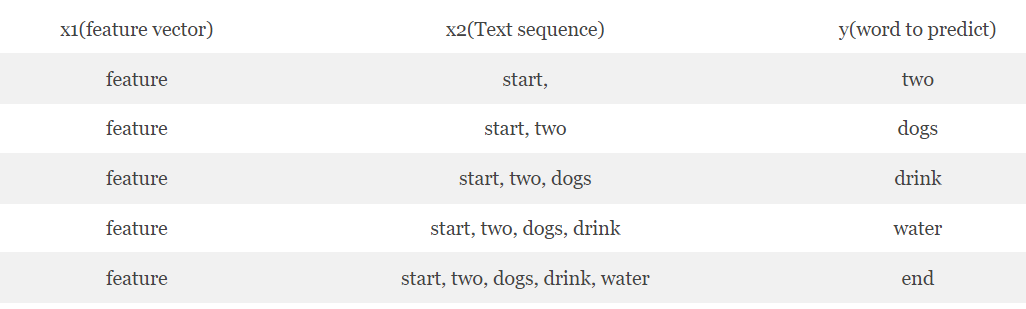

In [ ]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # Encoding the sequence
        seq = tokenizer.texts_to_sequences([desc])[0] # 2d to 1d

        # Creating the above mentioned pairing
        for i in range(1, len(seq)):
            
            in_seq, out_seq = seq[:i], seq[i]

            # Padding input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

            # Encoding output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [ ]:
#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape


((47, 2048), (47, 32), (47, 7577))

##**Defining the Model**

In [ ]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2) #  If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32


##**Training the model**

In [ ]:
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1939712     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 1013s 168ms/step - loss: 4.4911


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6000/6000 [==============================] - 1033s 172ms/step - loss: 2.7796


##**Testing the model**

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature


In [ ]:
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
  return None


In [ ]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text






start man skiing down snowy hill end


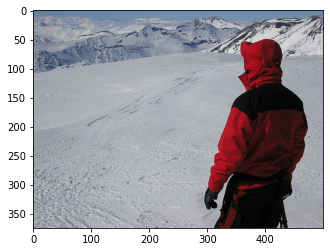

In [ ]:
img_path = '/content/Flicker8k_Dataset/1263801010_5c74bf1715.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('/content/model_7.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)